# Understanding ROC and PR Curves

This notebook provides a comprehensive comparison between ROC (Receiver Operating Characteristic) and PR (Precision-Recall) curves, including:
1. Creating synthetic data with different class imbalances
2. Training models
3. Plotting both ROC and PR curves
4. Analyzing when to use each type of curve
5. Implementing custom functions for better understanding

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, 
    average_precision_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)

# Set random seed for reproducibility
np.random.seed(42)

## 2. Create Datasets with Different Class Imbalances

In [2]:
def create_dataset(n_samples, imbalance_ratio, random_state=42):
    """Create a dataset with specified class imbalance ratio"""
    weights = [1 - imbalance_ratio, imbalance_ratio]  # [negative_class, positive_class]
    X, y = make_classification(
        n_samples=n_samples,
        n_classes=2,
        weights=weights,
        n_features=20,
        n_informative=15,
        random_state=random_state
    ) # classes will be labeled as 0 and 1; weights controls the proportion of samples for each class; 15 informative and 5 random noise
    return X, y

# Create two datasets: one balanced and one imbalanced
X_balanced, y_balanced = create_dataset(1000, 0.5)
X_imbalanced, y_imbalanced = create_dataset(1000, 0.1)

# Split both datasets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42
)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42
)

# Print class distributions
print('Balanced dataset class distribution:')
print(pd.Series(y_balanced).value_counts(normalize=True))
print('\nImbalanced dataset class distribution:')
print(pd.Series(y_imbalanced).value_counts(normalize=True))

Balanced dataset class distribution:
0    0.501
1    0.499
Name: proportion, dtype: float64

Imbalanced dataset class distribution:
0    0.899
1    0.101
Name: proportion, dtype: float64


## 3. Model Training and Evaluation Functions

In [3]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Train model and return predictions and metrics"""
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve metrics
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate PR curve metrics
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'roc_thresholds': roc_thresholds,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_thresholds': pr_thresholds,
        'avg_precision': avg_precision,
        'y_pred_proba': y_pred_proba
    }

## 4. Visualization Functions

In [4]:
def plot_roc_pr_curves(results_balanced, results_imbalanced):
    """Plot ROC and PR curves for both datasets"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot ROC curves
    ax1.plot(results_balanced['fpr'], results_balanced['tpr'], 
            label=f'Balanced (AUC = {results_balanced["roc_auc"]:.2f})')
    ax1.plot(results_imbalanced['fpr'], results_imbalanced['tpr'], 
            label=f'Imbalanced (AUC = {results_imbalanced["roc_auc"]:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True)
    
    # Plot PR curves
    ax2.plot(results_balanced['recall'], results_balanced['precision'], 
            label=f'Balanced (AP = {results_balanced["avg_precision"]:.2f})')
    ax2.plot(results_imbalanced['recall'], results_imbalanced['precision'], 
            label=f'Imbalanced (AP = {results_imbalanced["avg_precision"]:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## 5. Train Models and Generate Curves

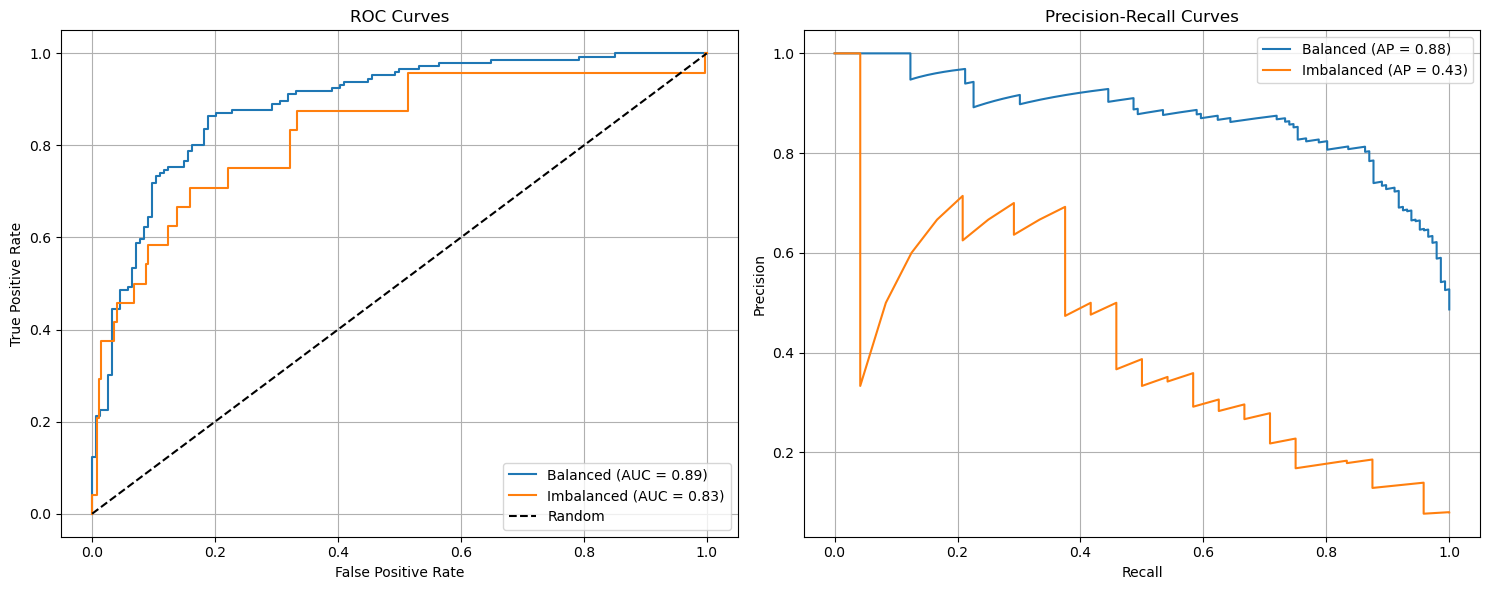

In [5]:
# Evaluate both datasets
results_balanced = train_and_evaluate(X_train_bal, X_test_bal, y_train_bal, y_test_bal)
results_imbalanced = train_and_evaluate(X_train_imb, X_test_imb, y_train_imb, y_test_imb)

# Plot the curves
plot_roc_pr_curves(results_balanced, results_imbalanced)

## 6. Threshold Analysis

In [6]:
def analyze_threshold_metrics(y_true, y_pred_proba, threshold):
    """Analyze various metrics at a specific threshold"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    print(f'Threshold: {threshold:.2f}')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'False Positive Rate: {fpr:.3f}')
    print('-------------------')

# Analyze thresholds for imbalanced dataset
print('Imbalanced Dataset Metrics:')
for threshold in [0.3, 0.5, 0.7]:
    analyze_threshold_metrics(y_test_imb, results_imbalanced['y_pred_proba'], threshold)

Imbalanced Dataset Metrics:
Threshold: 0.30
True Positives: 14
False Positives: 29
True Negatives: 247
False Negatives: 10
Precision: 0.326
Recall: 0.583
False Positive Rate: 0.105
-------------------
Threshold: 0.50
True Positives: 11
False Positives: 11
True Negatives: 265
False Negatives: 13
Precision: 0.500
Recall: 0.458
False Positive Rate: 0.040
-------------------
Threshold: 0.70
True Positives: 7
False Positives: 4
True Negatives: 272
False Negatives: 17
Precision: 0.636
Recall: 0.292
False Positive Rate: 0.014
-------------------


## 7. Key Differences Between ROC and PR Curves

### ROC Curves:
1. **What they show:**
   - Plot True Positive Rate (Sensitivity) vs False Positive Rate (1-Specificity)
   - Independent of class distribution
   - Area Under ROC (AUROC) measures overall ranking ability

2. **When to use:**
   - Balanced datasets
   - When both classes are equally important
   - When you want to evaluate performance across all thresholds

### PR Curves:
1. **What they show:**
   - Plot Precision vs Recall
   - Sensitive to class imbalance
   - Average Precision (AP) focuses on performance for positive class

2. **When to use:**
   - Imbalanced datasets
   - When positive class is more important
   - When false positives are costly

### Key Takeaways:
1. ROC curves can be overly optimistic for imbalanced datasets
2. PR curves better highlight the impact of false positives in imbalanced cases
3. Consider using both curves for a complete evaluation
4. Choose appropriate threshold based on your specific use case requirements